First: decentralized Graph classification

In [ ]:
!pip install spektral
!pip install tensorflow_privacy
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import Adam
from spektral.data import DisjointLoader
from spektral.datasets import TUDataset
from spektral.models import GeneralGNN
from google.colab import files
physical_devices = tf.config.list_physical_devices("GPU")
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [18]:
# Parmas
batch_size = 40
learning_rate = 0.001
epochs = 5
epoch_user = epochs 
epoch_server = 150   

In [180]:
# Data reading
data1 = TUDataset("Tox21_HSE_training")
# data1=data1[1:1113]
# Train/test split
np.random.shuffle(data1)
split1 = int(0.8 * len(data1))
data_tr1, data_te1 = data1[:split1], data1[split1:]
# Data loaders
loader_tr1 = DisjointLoader(data_tr1, batch_size=batch_size, epochs=epochs)
loader_te1 = DisjointLoader(data_te1, batch_size=batch_size)

data2 = TUDataset("Tox21_HSE_training")
# data2=data2[1:1113]
# Train/test split
np.random.shuffle(data2)
split2 = int(0.8 * len(data2))
data_tr2, data_te2 = data2[:split2], data2[split2:]
loader_tr2 = DisjointLoader(data_tr2, batch_size=batch_size, epochs=epochs)
loader_te2 = DisjointLoader(data_te2, batch_size=batch_size)

data3 = TUDataset("Tox21_HSE_training")
# data3=data3[1:1113]
# Train/test split
np.random.shuffle(data3)
split3 = int(0.8 * len(data3))
data_tr3, data_te3 = data3[:split3], data3[split3:]
loader_tr3 = DisjointLoader(data_tr3, batch_size=batch_size, epochs=epochs)
loader_te3 = DisjointLoader(data_te3, batch_size=batch_size)

100%|████████████████████████████████████████| 897k/897k [00:00<00:00, 1.71MB/s]


Successfully loaded Tox21_HSE_training.
Successfully loaded Tox21_HSE_training.
Successfully loaded Tox21_HSE_training.


In [181]:
print(data1.n_labels)

2


In [182]:
# Model creation and init:
################################################################################
# Build model
################################################################################
model = GeneralGNN(data1.n_labels, activation="softmax")
optimizer = Adam(learning_rate)
loss_fn = CategoricalCrossentropy()
global_model=model
model_Data1=model
model_Data2=model
model_Data3=model

In [161]:

import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.data import Dataset, DisjointLoader, Graph
from spektral.layers import GCSConv, GlobalAvgPool
from spektral.layers.pooling import TopKPool
from spektral.transforms.normalize_adj import NormalizeAdj

class Net(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = GCSConv(32, activation="relu")
        self.pool1 = TopKPool(ratio=0.5)
        self.conv2 = GCSConv(32, activation="relu")
        self.pool2 = TopKPool(ratio=0.5)
        self.conv3 = GCSConv(32, activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense = Dense(data.n_labels, activation="softmax")

    def call(self, inputs):
        x, a, i = inputs
        x = self.conv1([x, a])
        x1, a1, i1 = self.pool1([x, a, i])
        x1 = self.conv2([x1, a1])
        x2, a2, i2 = self.pool1([x1, a1, i1])
        x2 = self.conv3([x2, a2])
        output = self.global_pool([x2, i2])
        output = self.dense(output)

        return output

In [183]:
global_model = model
# global_model.append((model_Data1.trainable_weights[2:-2][0] + model_Data2.trainable_weights[2:-2][0] + model_Data3.trainable_weights[2:-2][0] )/3)
# global_model.append((model_Data1.trainable_weights[2:-2][1] + model_Data2.trainable_weights[2:-2][1] + model_Data3.trainable_weights[2:-2][1] )/3)

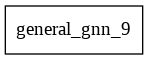

In [176]:
from tensorflow.python.keras.utils.vis_utils import plot_model

plot_model(global_model, show_shapes=True, show_layer_names=True, to_file='base-model.png')


In [184]:
print(data2.n_labels)
aa=model.get_weights
print(np.array(aa))

2
<bound method Model.get_weights of <spektral.models.general_gnn.GeneralGNN object at 0x7f51d793e110>>


In [165]:
def data_labels(loader):
  inputs, target = loader.__next__()
  return inputs, target

In [166]:
def apply_gradient(optimizer, loss_object, model, x, y):
  with tf.GradientTape() as tape:
    logits = model(x, training=True)
    loss_value = loss_object(y_true=y, y_pred=logits)
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))
  return loss_value, logits

In [185]:
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()
loss_object = tf.keras.losses.CategoricalCrossentropy()
loss_Data1_train = []
loss_Data1_valid = []
acc_Data1_train = []
acc_Data1_valid = []
loss_Data2_train = []
loss_Data2_valid = []
acc_Data2_train = []
acc_Data2_valid = []
loss_Data3_train = []
loss_Data3_valid = []
acc_Data3_train = []
acc_Data3_valid = []

Second: FedGNN training

In [187]:
# The thing is this.
for server_epoch in range(epoch_server):
  model_Data1.set_weights = global_model
  model_Data2.set_weights = global_model

  # loss
  loss_train_Data1 = 0
  loss_valid_Data1 = 0
  loss_train_Data2 = 0
  loss_valid_Data2 = 0
  loss_train_Data3 = 0
  loss_valid_Data3 = 0
  # acc
  acc_train_Data1 = 0
  acc_valid_Data1 = 0
  acc_train_Data2 = 0
  acc_valid_Data2 = 0
  acc_train_Data3 = 0
  acc_valid_Data3 = 0




  # Data1
  for user_epoch in range(epoch_user):
    # train
    # x = (loader_tr1[0].x, loader_tr1[0].a)
    # y = loader_tr1[0].y

    x, y = data_labels(loader_tr1)
    # mask = weights_tr_Data1
    loss_value, logits = apply_gradient(optimizer=optimizer, loss_object=loss_fn, model=model_Data1, x=x, y=y)
    train_acc_metric.update_state(y, tf.cast(tf.round(logits), tf.int64))
    loss_train_Data1 += loss_value
    acc_train_Data1 += train_acc_metric.result()
    # valid
    # mask = weights_va_Data1
    x, y = data_labels(loader_te1)
    val_logits = model_Data1(x, training=False)
    val_acc_metric.update_state(y, tf.cast(tf.round(val_logits), tf.int64))
    loss_valid_Data1 += loss_object(y_true=y, y_pred=val_logits)
    acc_valid_Data1 += val_acc_metric.result()
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()

# Data2
  for user_epoch in range(epoch_user):
    # train
    # x = (loader_tr1[0].x, loader_tr1[0].a)
    # y = loader_tr1[0].y

    x, y = data_labels(loader_tr2)
    # mask = weights_tr_Data1
    loss_value, logits = apply_gradient(optimizer=optimizer, loss_object=loss_fn, model=model_Data2, x=x, y=y)
    train_acc_metric.update_state(y, tf.cast(tf.round(logits), tf.int64))
    loss_train_Data2 += loss_value
    acc_train_Data2 += train_acc_metric.result()
    # valid
    x, y = data_labels(loader_te2)
    # mask = weights_va_Data1
    val_logits = model_Data2(x, training=False)
    val_acc_metric.update_state(y, tf.cast(tf.round(val_logits), tf.int64))
    loss_valid_Data2 += loss_object(y_true=y, y_pred=val_logits)
    acc_valid_Data2 += val_acc_metric.result()
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()
  

# Data3
  for user_epoch in range(epoch_user):
    # train
    # x = (loader_tr1[0].x, loader_tr1[0].a)
    # y = loader_tr1[0].y

    x, y = data_labels(loader_tr3)
    # mask = weights_tr_Data1
    loss_value, logits = apply_gradient(optimizer=optimizer, loss_object=loss_fn, model=model_Data3, x=x, y=y)
    train_acc_metric.update_state(y, tf.cast(tf.round(logits), tf.int64))
    loss_train_Data3 += loss_value
    acc_train_Data3 += train_acc_metric.result()
    # valid
    x, y = data_labels(loader_te3)
    # mask = weights_va_Data1
    val_logits = model_Data3(x, training=False)
    val_acc_metric.update_state(y, tf.cast(tf.round(val_logits), tf.int64))
    loss_valid_Data3 += loss_object(y_true=y, y_pred=val_logits)
    acc_valid_Data3 += val_acc_metric.result()
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()


  #global model update
  # global_model = []
  # upd1=(model_Data1.get_weights)
  # upd2=(model_Data2.get_weights)
  # upd3=(model_Data3.get_weights)

  # avg=upd1+upd2
  # global_model.set_weights=(avg)
  global_model = []
  global_model.append((model_Data1.trainable_weights[2:-2][0] + model_Data2.trainable_weights[2:-2][0] + model_Data3.trainable_weights[2:-2][0] )/3)
  global_model.append((model_Data1.trainable_weights[2:-2][1] + model_Data2.trainable_weights[2:-2][1] + model_Data3.trainable_weights[2:-2][1] )/3)



  # loss
  loss_Data1_train.append(loss_train_Data1/epoch_user)
  loss_Data2_train.append(loss_train_Data2/epoch_user)
  loss_Data3_train.append(loss_train_Data3/epoch_user)
  loss_Data1_valid.append(loss_valid_Data1/epoch_user)
  loss_Data2_valid.append(loss_valid_Data2/epoch_user)
  loss_Data3_valid.append(loss_valid_Data3/epoch_user)


  # acc
  acc_Data1_train.append(acc_train_Data1/epoch_user)
  acc_Data1_valid.append(acc_valid_Data1/epoch_user)
  acc_Data2_train.append(acc_train_Data2/epoch_user)
  acc_Data2_valid.append(acc_valid_Data2/epoch_user)
  acc_Data3_train.append(acc_train_Data3/epoch_user)
  acc_Data3_valid.append(acc_valid_Data3/epoch_user)


  print("Epoch {:03d}: Train Data1 Loss: {:.7f}, Train Data1 Accuracy: {:.3%}, Valid Data1 Loss: {:.7f}, Valid Data1 Accuracy: {:.3%}".format(server_epoch, loss_train_Data1/epoch_user, acc_train_Data1/epoch_user, loss_valid_Data1/epoch_user, acc_valid_Data1/epoch_user))
  print("Epoch {:03d}: Train Data2 Loss: {:.7f}, Train Data2 Accuracy: {:.3%}, Valid Data2 Loss: {:.7f}, Valid Data2 Accuracy: {:.3%}".format(server_epoch, loss_train_Data2/epoch_user, acc_train_Data2/epoch_user, loss_valid_Data2/epoch_user, acc_valid_Data2/epoch_user))
  print("Epoch {:03d}: Train Data3 Loss: {:.7f}, Train Data3 Accuracy: {:.3%}, Valid Data3 Loss: {:.7f}, Valid Data3 Accuracy: {:.3%}".format(server_epoch, loss_train_Data3/epoch_user, acc_train_Data3/epoch_user, loss_valid_Data3/epoch_user, acc_valid_Data3/epoch_user))

ValueError: ignored

In [156]:
from google.colab import files

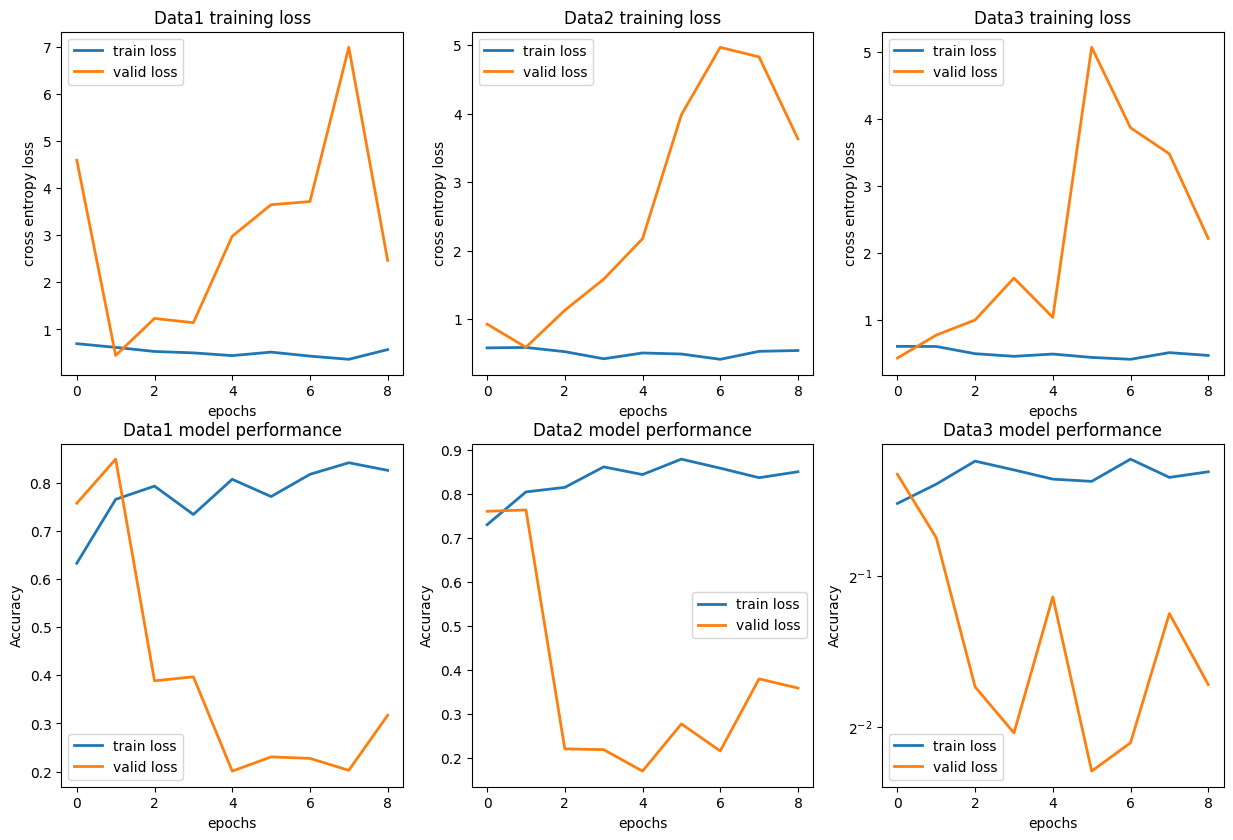

In [179]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10), dpi=100)
#Data1 
axes[0][0].plot(loss_Data1_train, label='train loss', linewidth=2)
axes[0][0].plot(loss_Data1_valid, label='valid loss', linewidth=2)
axes[0][0].set_ylabel("cross entropy loss")
axes[0][0].set_xlabel("epochs")
axes[0][0].set_title("Data1 training loss")
axes[0][0].legend()

axes[1][0].plot(acc_Data1_train, label='train loss', linewidth=2)
axes[1][0].plot(acc_Data1_valid, label='valid loss', linewidth=2)
axes[1][0].set_ylabel("Accuracy")
axes[1][0].set_xlabel("epochs")
axes[1][0].set_title("Data1 model performance")
axes[1][0].legend()

# Data2
axes[0][1].plot(loss_Data2_train, label='train loss', linewidth=2)
axes[0][1].plot(loss_Data2_valid, label='valid loss', linewidth=2)
axes[0][1].set_ylabel("cross entropy loss")
axes[0][1].set_xlabel("epochs")
axes[0][1].set_title("Data2 training loss")
axes[0][1].legend()

axes[1][1].plot(acc_Data2_train, label='train loss', linewidth=2)
axes[1][1].plot(acc_Data2_valid, label='valid loss', linewidth=2)
axes[1][1].set_ylabel("Accuracy")
axes[1][1].set_xlabel("epochs")
axes[1][1].set_title("Data2 model performance")
axes[1][1].legend()

# Data3
axes[0][2].plot(loss_Data3_train, label='train loss', linewidth=2)
axes[0][2].plot(loss_Data3_valid, label='valid loss', linewidth=2)
axes[0][2].set_ylabel("cross entropy loss")
axes[0][2].set_xlabel("epochs")
axes[0][2].set_title("Data3 training loss")
axes[0][2].legend()

axes[1][2].plot(acc_Data3_train, label='train loss', linewidth=2)
axes[1][2].plot(acc_Data3_valid, label='valid loss', linewidth=2)
axes[1][2].set_ylabel("Accuracy")
axes[1][2].set_xlabel("epochs")
axes[1][2].set_title("Data3 model performance")
axes[1][2].legend()

plt.yscale('log',  basey=2)
plt.savefig("fed_grah_Classification_results_DD.pdf")
# files.download("fed_grah_Classification_results_DD.pdf") 

In [ ]:
from google.colab import files
import pandas as pd


In [ ]:
plt.plot(loss_Data1_train)
plt.plot(loss_Data1_valid)

plt.plot(loss_Data2_train)
plt.plot(loss_Data2_valid)

plt.plot(loss_Data3_train)
plt.plot(loss_Data3_valid)